In [6]:
!python3 -m pip install seaborn

     |████████████████████████████████| 292 kB 376 kB/s eta 0:00:01


In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
import itertools
import pandas as pd

In [2]:
## Matplotlib defaults ##
colors = {"5": "#aa0f35", 
         "6": "#fdc799",
         "7": "#a0a75c",
         "8": "#603734",
         "9": "#abdbfc",
         "10": "#313a61",
         "15": "#bfbad5",
         "20": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Overview

Analyze assembly index calculations across patent data. These calculations are from random samples of compounds present in each month from 1980-2019.

//TODO: sample from new compounds added in each month

In [3]:
fp = "Data/AssemblyValues/assembly_values_1000_1980.p"
assembly_values = pickle.load(file=open(fp, "rb"))

In [4]:
print(assembly_values[100:199])

[{'month': '1980-01', 'inchi': 'InChI=1S/C17H35Cl.H3N/c1-5-6-7-8-9-10-11-12-13-14-15-16(2)17(3,4)18;/h16H,5-15H2,1-4H3;1H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-16-10-25(11-17(2)22(16)7)28(26-12-18(3)23(8)19(4)13-26)27-14-20(5)24(9)21(6)15-27/h10-15H,1-9H3', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-7-22-10-19(4)13-25(16-22)28(26-14-20(5)11-23(8-2)17-26)27-15-21(6)12-24(9-3)18-27/h10-18H,7-9H2,1-6H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C30H39P/c1-28(2,3)22-13-10-16-25(19-22)31(26-17-11-14-23(20-26)29(4,5)6)27-18-12-15-24(21-27)30(7,8)9/h10-21H,1-9H3', 'ai': 20}, {'month': '1980-01', 'inchi': 'InChI=1S/C18H31N/c1-2-3-4-5-15-6-10-17(11-7-15)18-12-8-16(14-19)9-13-18/h15-18H,2-13H2,1H3', 'ai': 9}, {'month': '1980-01', 'inchi': 'InChI=1S/C16H17NO2/c18-16(19)14-10-4-5-11-15(14)17-12-6-9-13-7-2-1-3-8-13/h1-5,7-8,10-11,17H,6,9,12H2,(H,18,19)', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C20H32O2/c1-12-10-14(21)11-13-4-5-15-16

In [5]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [6]:
months = build_month_increments(1980, 1980)
print(months)

['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06', '1980-07', '1980-08', '1980-09', '1980-10', '1980-11', '1980-12']


# New / Total Compound Assemblies

There are varying numbers of compounds for each month - so it's necessary to make separate lists for each month. These are stored in a dictionary {month: [assembly values]}

### Plotting

Plot mean, standard deviation, other data for each month

Using two files = fullCpds_ & newCpds_AssemblyValues.csv in Data/AssemblyValues

Goal = get average & std MA, as well as average avg MW, for each month

In [14]:
full_df = pd.read_csv("Data/AssemblyValues/fullCpds_AssemblyValues.csv")
new_df = pd.read_csv("Data/AssemblyValues/newCpds_AssemblyValues.csv")
print(full_df.head())
print("----------------------------------")
print(new_df.head())

   Unnamed: 0    month                                              inchi  ai  \
0           0  1980-01  InChI=1S/C18H36O2.Mg/c1-2-3-4-5-6-7-8-9-10-11-...   8   
1           1  1980-01  InChI=1S/C50H71N13O12/c1-5-28(4)41(47(72)59-36...  77   
2           2  1980-01  InChI=1S/C11H18N2O3.Na/c1-4-6-7(3)11(5-2)8(14)...  13   
3           3  1980-01  InChI=1S/C10H11ClO/c1-8(12)2-3-9-4-6-10(11)7-5...   8   
4           4  1980-01  InChI=1S/C14H11Cl2NO2/c15-10-5-3-6-11(16)14(10...  14   

            mw  
0   308.256572  
1  1045.534515  
2   248.113687  
3   182.049843  
4   295.016684  
----------------------------------
   Unnamed: 0    month                                              inchi  ai  \
0           0  1980-01  InChI=1S/C10H14O4/c1-7(2-3-8-4-12-8)10(11)14-6...  10   
1           1  1980-01  InChI=1S/C15H10O5/c16-9-3-1-8(2-4-9)15-13(19)7...  14   
2           2  1980-01  InChI=1S/C10H18N4O4S3/c1-7(19-5)11-17-9(15)13(...  18   
3           3  1980-01  InChI=1S/C7H13NO/c1-2-4-7-6(

In [15]:
#Average MA values per month
full_stats = full_df.groupby(["month"]).agg({"ai":["mean","std"],"mw":["mean"]})
new_stats = new_df.groupby(["month"]).agg({"ai":["mean","std"],"mw":["mean"]})

print(full_stats)
print("----------------------------------")
print(new_stats)

                ai                     mw
              mean        std        mean
month                                    
1980-01  14.542477   8.578500  288.903786
1980-02  14.957113   9.432218  296.885756
1980-03  14.758230   8.803624  294.906152
1980-04  15.343189   9.410054  301.813923
1980-05  15.006224   9.419604  294.044223
...            ...        ...         ...
2019-08  23.524145  15.969379  404.242385
2019-09  24.048780  18.210526  404.686906
2019-10  24.800403  17.323901  414.404896
2019-11  24.421748  19.445047  413.057041
2019-12  22.172239  16.789918  382.471763

[480 rows x 3 columns]
----------------------------------
                ai                     mw
              mean        std        mean
month                                    
1980-01  17.805846   9.699448  336.580176
1980-02  17.781218   8.823664  337.134343
1980-03  17.573045   8.388716  336.756317
1980-04  17.953608   8.701263  339.631414
1980-05  17.264859  11.150925  336.565682
...            ..

Text(0, 0.5, 'Assembly Index')

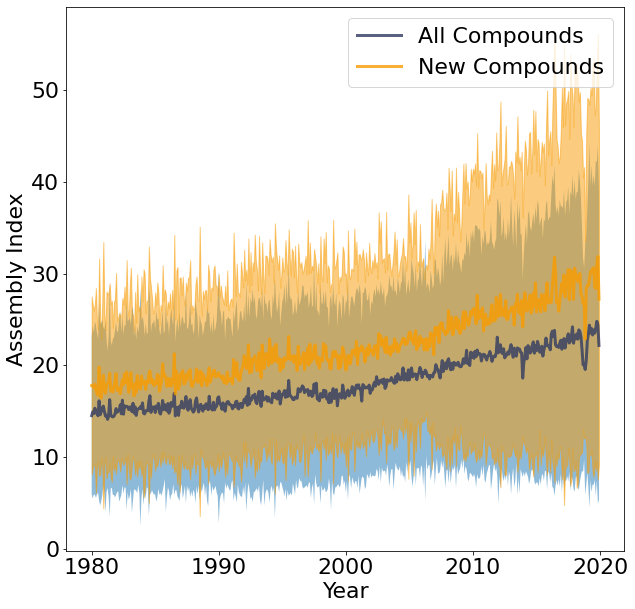

In [21]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

# plt.errorbar(np.arange(1980, 2019, 1/12), full_month_avgs, yerr=full_month_stds, color="#313a61",
#             elinewidth=1, linewidth=3, markersize=10, alpha=0.8, label="All Compounds")
plt.plot(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")
plt.fill_between(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"] - full_stats["ai"]["std"], 
                full_stats["ai"]["mean"] + full_stats["ai"]["std"], alpha=0.5)

# # plt.errorbar(np.arange(1980, 2019, 1/12), new_month_avgs, yerr=new_month_stds, color="#f89b00",
# #             elinewidth=1, linewidth=3, markersize=10, alpha=0.4, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")
plt.fill_between(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"] - new_stats["ai"]["std"], 
                new_stats["ai"]["mean"] + new_stats["ai"]["std"], alpha=0.5, color="#f89b00")

#plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

Text(0, 0.5, 'Assembly Index')

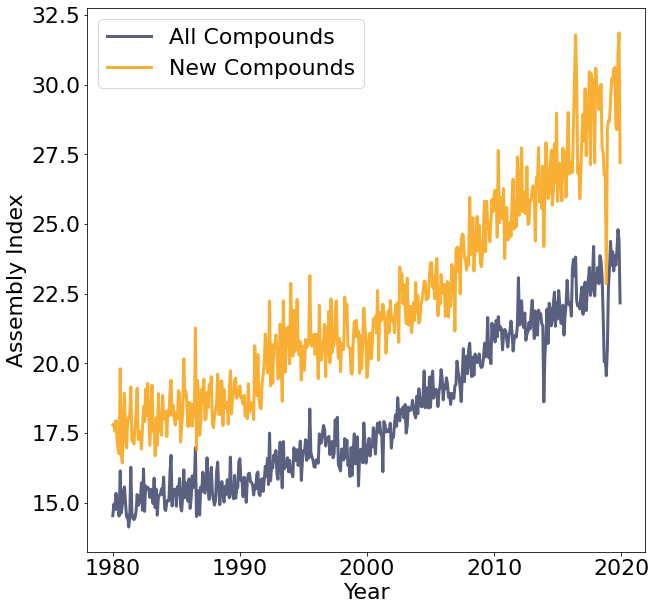

In [22]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.plot(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

## Expected Assembly Values

Based on linear regression of a large assortment of assembly values (in ~/Lab/AssemblyValues/)

x = 0.0456; b = 2.4826

In [27]:
#Add a "expected assembly value" column to each results dataframe
full_stats["ExpectedMA"] = 2.4826 + 0.0456*full_stats["mw"]["mean"]
new_stats["ExpectedMA"] = 2.4826 + 0.0456*new_stats["mw"]["mean"]

Text(0, 0.5, 'Assembly Index')

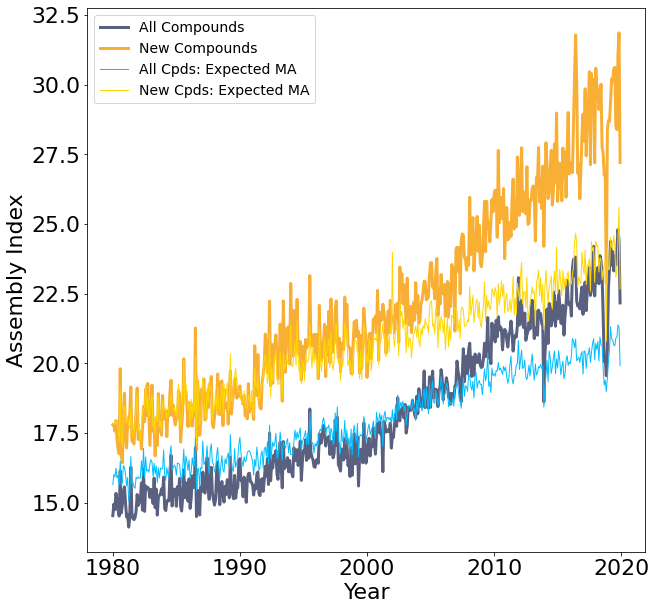

In [34]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

xs = np.arange(1980, 2020, 1/12)

#Average assembly Values
plt.plot(xs, full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.plot(xs, new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

#Expected MA values
plt.plot(xs, full_stats["ExpectedMA"], color="deepskyblue", linewidth=1, label="All Cpds: Expected MA")
plt.plot(xs, new_stats["ExpectedMA"], color="gold", linewidth=1, label="New Cpds: Expected MA")

plt.legend(prop={"size":14})
plt.xlabel("Year")
plt.ylabel("Assembly Index")

# Changing Compounds Assemblies

Analyze the assembly values of fast-changing (min & max percentiles) compounds

Sets to analyze:
1. Compounds in 99.99th percentile
2. Changing compounds, 99.99th percentile (maxPercentile_0.01_99.99*)
3. Changing compounds, below 0.01st percentile (minPercentile_0.01_99.99*)
4. Changing compounds, 99.9th percentile (maxPercentile_0.1_99.9*)
5. Changing compounds, below 0.1st percentile (minPercentile_0.1_99.9*) 

In [4]:
## Matplotlib defaults ##
colors = {"1980": "#aa0f35", 
         "1985": "#fdc799",
         "1990": "#abdbfc",
         "1995": "#a0a75c",
         "2000": "#603734",
         "2005": "#009ecb",
         "2010": "#430057",
         "2015": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

### Compounds in 99.99th percentile 

Plot & analyze the most connected compounds in SureChemBL

------  (2015, 2019) -----
DescribeResult(nobs=722, minmax=(1, 119), mean=15.637119113573407, variance=256.75579085680477, skewness=3.308937717875287, kurtosis=12.829833350312803)
------  (2010, 2014) -----
DescribeResult(nobs=695, minmax=(1, 119), mean=15.751079136690647, variance=284.97973586548625, skewness=3.264398959689537, kurtosis=11.761944878282671)
------  (2005, 2009) -----
DescribeResult(nobs=540, minmax=(1, 119), mean=17.15, variance=354.5655844155844, skewness=2.748878893799469, kurtosis=7.721047532280789)
------  (2000, 2004) -----
DescribeResult(nobs=265, minmax=(1, 100), mean=16.60377358490566, variance=346.93710691823895, skewness=2.4396828094647396, kurtosis=5.448874109651744)
------  (1995, 1999) -----
DescribeResult(nobs=163, minmax=(2, 87), mean=15.50920245398773, variance=322.7082481254261, skewness=2.2988947899026977, kurtosis=4.296780402120956)
------  (1990, 1994) -----
DescribeResult(nobs=126, minmax=(3, 87), mean=16.73015873015873, variance=393.7986031746031,

Text(0, 0.5, 'Compound Density')

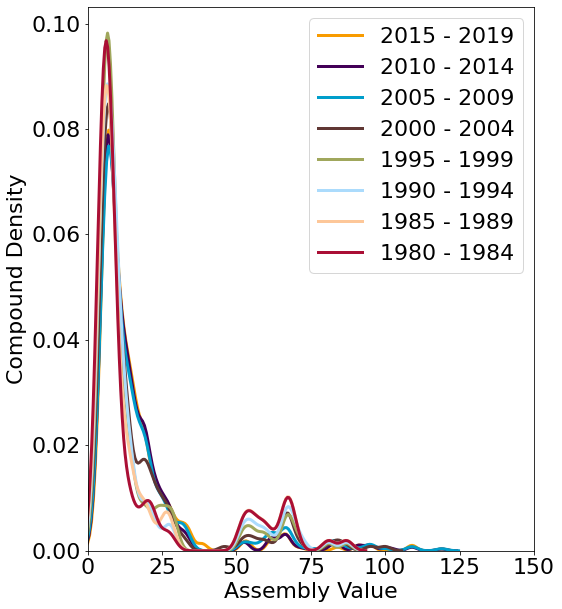

In [48]:
pairs = [(1980, 1984), (1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_above99_99percentile" + str(start) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    
    #plt.hist(ais, bins=100, color=colors[str(start)], label= str(start) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.1, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)

plt.legend()
plt.xlim(0,150)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [54]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.011891428685306602, pvalue=0.9999999977077801)
Anderson_ksampResult(statistic=-1.0699860338119844, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.5383247972259305

(0, 2)
KstestResult(statistic=0.03345644813788858, pvalue=0.864307761582229)
Anderson_ksampResult(statistic=-0.7580090187166283, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.5986713860675081

(0, 3)
KstestResult(statistic=0.07503789264621336, pvalue=0.21189782394499013)
Anderson_ksampResult(statistic=2.095567746527271, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.044571432106303426)
Wasserstein Distance: 2.4402341504207357

(0, 4)
KstestResult(statistic=0.15266896657206463, pvalue=0.00355205398259939)
Anderson_ksampResult(statistic=7.680779381202069, critical_values=array([0.325, 1.226, 1.961,

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """
c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value floored: true value smaller than 0.001
  """


Anderson_ksampResult(statistic=9.969150247135532, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Wasserstein Distance: 4.8081519663993895

(3, 4)
KstestResult(statistic=0.07952309295057298, pvalue=0.5130898912449378)
Anderson_ksampResult(statistic=0.4417356012385059, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21880182947808205)
Wasserstein Distance: 1.445630281282555

(3, 5)
KstestResult(statistic=0.0746031746031746, pvalue=0.6925072704114961)
Anderson_ksampResult(statistic=0.08146284297910673, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.2620545073375258

(3, 6)
KstestResult(statistic=0.10302672955974843, pvalue=0.4094223190343369)
Anderson_ksampResult(statistic=0.4713304271827982, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21247405604335284)
Wasserstein

### Changing compounds, 99.9th percentile 

------  (2015, 2019) -----
DescribeResult(nobs=255, minmax=(2, 72), mean=10.011764705882353, variance=70.38962482630848, skewness=3.9867883140560094, kurtosis=20.504278861694107)

------  (2010, 2014) -----
DescribeResult(nobs=192, minmax=(2, 72), mean=9.916666666666666, variance=75.68935427574172, skewness=4.255366022937834, kurtosis=22.321515447802124)

------  (2005, 2009) -----
DescribeResult(nobs=44, minmax=(3, 59), mean=11.272727272727273, variance=159.69133192389006, skewness=2.8373976748006977, kurtosis=7.087474216438332)

------  (2000, 2004) -----
DescribeResult(nobs=11, minmax=(5, 28), mean=10.272727272727273, variance=41.41818181818182, skewness=2.0420616823932276, kurtosis=3.4622930639371434)

------  (1995, 1999) -----
DescribeResult(nobs=143, minmax=(2, 72), mean=10.23076923076923, variance=94.27735644637053, skewness=4.001581217375285, kurtosis=18.41325504799777)

------  (1990, 1994) -----
DescribeResult(nobs=193, minmax=(2, 72), mean=9.963730569948186, variance=76.587

Text(0, 0.5, 'Compound Density')

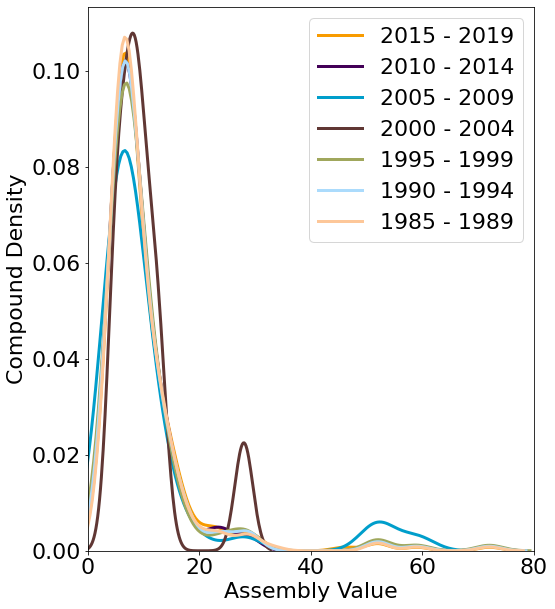

In [49]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_maxPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [56]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.01997549019607843, pvalue=0.9999999995237022)
Anderson_ksampResult(statistic=-1.2325645468887758, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.2848039215686279

(0, 2)
KstestResult(statistic=0.08360071301247772, pvalue=0.9325351708624212)
Anderson_ksampResult(statistic=-0.49182366723549, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.154545454545455

(0, 3)
KstestResult(statistic=0.22923351158645278, pvalue=0.5602536950607762)
Anderson_ksampResult(statistic=-0.7006021084284263, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.7283422459893059

(0, 4)
KstestResult(statistic=0.02243246949129302, pvalue=0.9999999981044085)
Anderson_ksampResult(statistic=-1.2121593830680966, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


### Changing compounds, below 0.1st percentile 


------  (2015, 2019) -----
DescribeResult(nobs=14, minmax=(5, 23), mean=9.214285714285714, variance=19.719780219780223, skewness=2.2753652312810235, kurtosis=4.823006522592599)

------  (2010, 2014) -----
DescribeResult(nobs=33, minmax=(5, 23), mean=8.181818181818182, variance=11.090909090909088, skewness=2.7821910406362513, kurtosis=9.941764226686384)

------  (2005, 2009) -----
DescribeResult(nobs=151, minmax=(3, 53), mean=9.655629139072847, variance=36.84061810154526, skewness=3.627597139606427, kurtosis=18.859142589807984)

------  (2000, 2004) -----
DescribeResult(nobs=389, minmax=(3, 81), mean=10.352185089974293, variance=39.69265629555031, skewness=4.987640846788539, kurtosis=45.03610802378697)

------  (1995, 1999) -----
DescribeResult(nobs=216, minmax=(3, 53), mean=9.787037037037036, variance=32.43815676141257, skewness=3.3281999121769847, kurtosis=17.82198377577295)

------  (1990, 1994) -----
DescribeResult(nobs=434, minmax=(2, 81), mean=10.264976958525345, variance=42.84186

Text(0, 0.5, 'Compound Density')

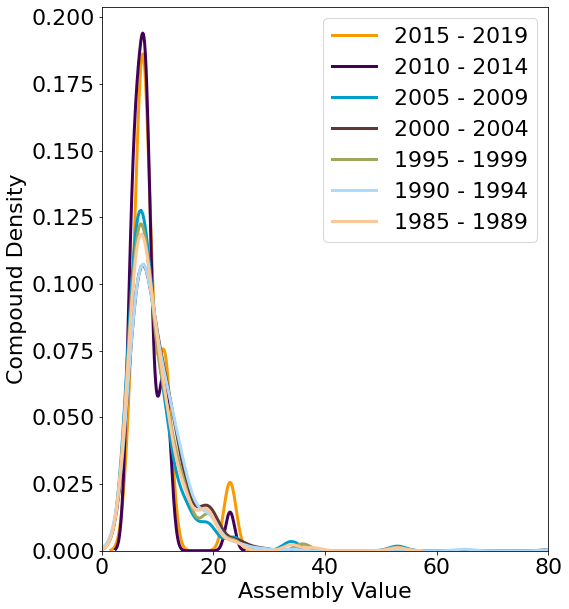

In [50]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_minPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [58]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.16017316017316016, pvalue=0.9137835326059303)
Anderson_ksampResult(statistic=-0.6886537335030235, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.0324675324675323

(0, 2)
KstestResult(statistic=0.16177861873226113, pvalue=0.8342558375814302)
Anderson_ksampResult(statistic=-0.8290556286861674, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.1556291390728484

(0, 3)
KstestResult(statistic=0.15956665442526624, pvalue=0.8283453243806849)
Anderson_ksampResult(statistic=-0.33110729841668524, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.6972089607051064

(0, 4)
KstestResult(statistic=0.14417989417989419, pvalue=0.9095928141227335)
Anderson_ksampResult(statistic=-0.7078635438065096, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


## Assembly / Degree Correlation

In [10]:
#Read in assembly data
data = pickle.load(file=open("Data/AssemblyDegreeCorr/TESTFULLIDS_assemblyValues.p", "rb"))
data = data[0]


<class 'list'>
9271
{'mc_ai': 10, 'frag_ai': 9, 'inchi': 'InChI=1S/C14H10O2/c15-13(11-7-3-1-4-8-11)14(16)12-9-5-2-6-10-12/h1-10H'}


In [32]:
#Read in degree data (I think...)
degree_df = pd.read_csv("Data/AssemblyDegreeCorr/sample_byDegreeQuantile_2019-12.csv")
degree_df = degree_df.rename({"Unnamed: 0": "SureChEMBL_ID"}, axis=1)
print(degree_df)

structure_df = pd.read_csv("Data/AssemblyDegreeCorr/sample_TESTFULLIDS_2019-12.csv")
print(structure_df)

        SureChEMBL_ID  Degree  quantile
0       SCHEMBL121895       4         0
1       SCHEMBL249368      17         0
2     SCHEMBL14695391       9         0
3      SCHEMBL1418691      19         0
4      SCHEMBL4394698      11         0
...               ...     ...       ...
9370     SCHEMBL83796   17996        49
9371     SCHEMBL37162   18007        49
9372     SCHEMBL25918   18603        49
9373     SCHEMBL27798   21644        49
9374     SCHEMBL26078   16948        49

[9375 rows x 3 columns]
      Unnamed: 0    SureChEMBL_ID  \
0             26        SCHEMBL66   
1            106       SCHEMBL220   
2            133       SCHEMBL263   
3            218       SCHEMBL398   
4            229       SCHEMBL414   
...          ...              ...   
9266    19781913  SCHEMBL21610045   
9267    19781938  SCHEMBL21610072   
9268    19781970  SCHEMBL21610105   
9269    19781974  SCHEMBL21610109   
9270    19781985  SCHEMBL21610120   

                                                 S

In [33]:
#DataFrame of data
ma_df = pd.DataFrame(data)
ma_df = ma_df.rename({"inchi": "InChI"}, axis=1)
print(ma_df)

      mc_ai  frag_ai                                              InChI
0        10        9  InChI=1S/C14H10O2/c15-13(11-7-3-1-4-8-11)14(16...
1         9        7  InChI=1S/C8H4O3/c9-7-5-3-1-2-4-6(5)8(10)11-7/h...
2        11       10  InChI=1S/C19H15Br/c20-19(16-10-4-1-5-11-16,17-...
3         4        6   InChI=1S/C6H14O3/c1-7-3-5-9-6-4-8-2/h3-6H2,1-2H3
4        10        9  InChI=1S/C10H10N2/c1-2-4-10(5-3-1)8-12-7-6-11-...
...     ...      ...                                                ...
9266     16       14  InChI=1S/C25H37N/c1-15(2)22-14-21(12-19(8)23(2...
9267      8        7  InChI=1S/C7H16N2OS/c1-8-3-4-9(11)7(6-8)2-5-10/...
9268     34       34  InChI=1S/C30H35ClFN7O3/c1-17(2)39-27(18(3)15-3...
9269     12       11  InChI=1S/C10H22N2O2S/c1-9(15)7-12(5-6-14-4)8-1...
9270     25       20  InChI=1S/C26H25ClFN3OS/c1-4-9-30-13-15(2)31(16...

[9271 rows x 3 columns]


In [35]:
#merge all dataframes so that MA values align with degrees
df = pd.merge(ma_df, structure_df)
df = pd.merge(df, degree_df)
print(df)

      mc_ai  frag_ai                                              InChI  \
0        10        9  InChI=1S/C14H10O2/c15-13(11-7-3-1-4-8-11)14(16...   
1         9        7  InChI=1S/C8H4O3/c9-7-5-3-1-2-4-6(5)8(10)11-7/h...   
2        11       10  InChI=1S/C19H15Br/c20-19(16-10-4-1-5-11-16,17-...   
3         4        6   InChI=1S/C6H14O3/c1-7-3-5-9-6-4-8-2/h3-6H2,1-2H3   
4        10        9  InChI=1S/C10H10N2/c1-2-4-10(5-3-1)8-12-7-6-11-...   
...     ...      ...                                                ...   
9274     16       14  InChI=1S/C25H37N/c1-15(2)22-14-21(12-19(8)23(2...   
9275      8        7  InChI=1S/C7H16N2OS/c1-8-3-4-9(11)7(6-8)2-5-10/...   
9276     34       34  InChI=1S/C30H35ClFN7O3/c1-17(2)39-27(18(3)15-3...   
9277     12       11  InChI=1S/C10H22N2O2S/c1-9(15)7-12(5-6-14-4)8-1...   
9278     25       20  InChI=1S/C26H25ClFN3OS/c1-4-9-30-13-15(2)31(16...   

      Unnamed: 0    SureChEMBL_ID  \
0             26        SCHEMBL66   
1            106       SC

In [36]:
#Correlation between mc_ai, frag_ai, and Degree
df.corr()

,mc_ai,frag_ai,Unnamed: 0,Degree,quantile
mc_ai,1.000000,0.497689,0.372811,-0.018356,0.058976
frag_ai,0.497689,1.000000,0.334580,0.007958,0.101778
Unnamed: 0,0.372811,0.334580,1.000000,-0.182788,0.020152
Degree,-0.018356,0.007958,-0.182788,1.000000,0.491245
quantile,0.058976,0.101778,0.020152,0.491245,1.000000


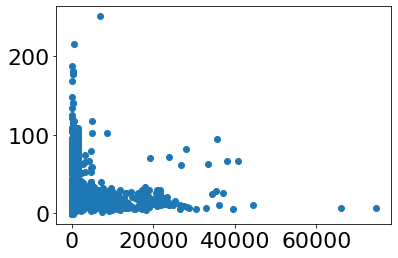

In [39]:
#Visual representation of 0 correlation (lol)
plt.Figure(figsize=(8,8))
plt.scatter(df["Degree"], df["mc_ai"])

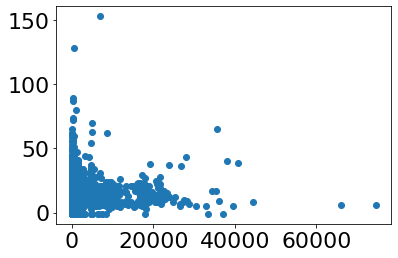

In [40]:
plt.Figure(figsize=(8,8))
plt.scatter(df["Degree"], df["frag_ai"])

Note for later - maybe there's something here, or at least a bound of MA values as degree increases?